<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_4/3_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

### Data Transformations

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

### Dataset and creating train/ test split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader arguments and test/ train dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Data statistics

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


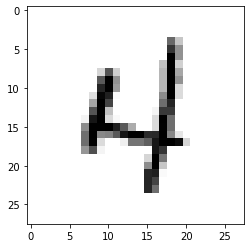

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

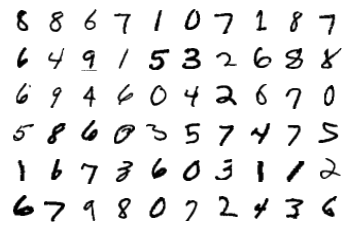

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [7]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )  # ip = 28 | op = 28 | RF = 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )  # ip = 28 | op = 26 | RF = 


        # CONVOLUTION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        ) # ip = 26 | op = 24 | RF = 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # ip = 24 | op = 12 | RF = 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        ) # ip = 12 | op = 12 | RF = 

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        ) # ip = 12 | op = 10 | RF = 
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        ) # ip = 10 | op = 8 | RF = 
        self.pool2 = nn.MaxPool2d(2, 2) # ip = 8 | op = 4 | RF = 
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        ) # ip = 4 | op = 4 | RF = 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(4, 4), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # ip = 4 | op = 1 | RF = 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model parameters

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4            [-1, 8, 26, 26]             576
       BatchNorm2d-5            [-1, 8, 26, 26]              16
              ReLU-6            [-1, 8, 26, 26]               0
            Conv2d-7           [-1, 16, 24, 24]           1,152
       BatchNorm2d-8           [-1, 16, 24, 24]              32
              ReLU-9           [-1, 16, 24, 24]               0
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11            [-1, 8, 12, 12]             128
      BatchNorm2d-12            [-1, 8, 12, 12]              16

### Training and testing

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

### Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.06610202044248581 Batch_id=468 Accuracy=94.19: 100%|██████████| 469/469 [00:17<00:00, 26.10it/s]



Test set: Average loss: 0.0704, Accuracy: 9784/10000 (97.84%)

EPOCH: 1


Loss=0.013415105640888214 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0517, Accuracy: 9842/10000 (98.42%)

EPOCH: 2


Loss=0.056125324219465256 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 31.85it/s]



Test set: Average loss: 0.0397, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.016346562653779984 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]



Test set: Average loss: 0.0349, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.005301191937178373 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]



Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.0038715440314263105 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.0281, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.0037298204842954874 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]



Test set: Average loss: 0.0278, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.0050190952606499195 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]



Test set: Average loss: 0.0284, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.007525971159338951 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]



Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.013412721455097198 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.0265, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.01073099672794342 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.007446200121194124 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]



Test set: Average loss: 0.0292, Accuracy: 9906/10000 (99.06%)

EPOCH: 12


Loss=0.005729893688112497 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]



Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)

EPOCH: 13


Loss=0.003697152016684413 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]



Test set: Average loss: 0.0280, Accuracy: 9914/10000 (99.14%)

EPOCH: 14


Loss=0.0007952721207402647 Batch_id=468 Accuracy=99.81: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.0270, Accuracy: 9924/10000 (99.24%)



### Plotting

Text(0.5, 1.0, 'Test Accuracy')

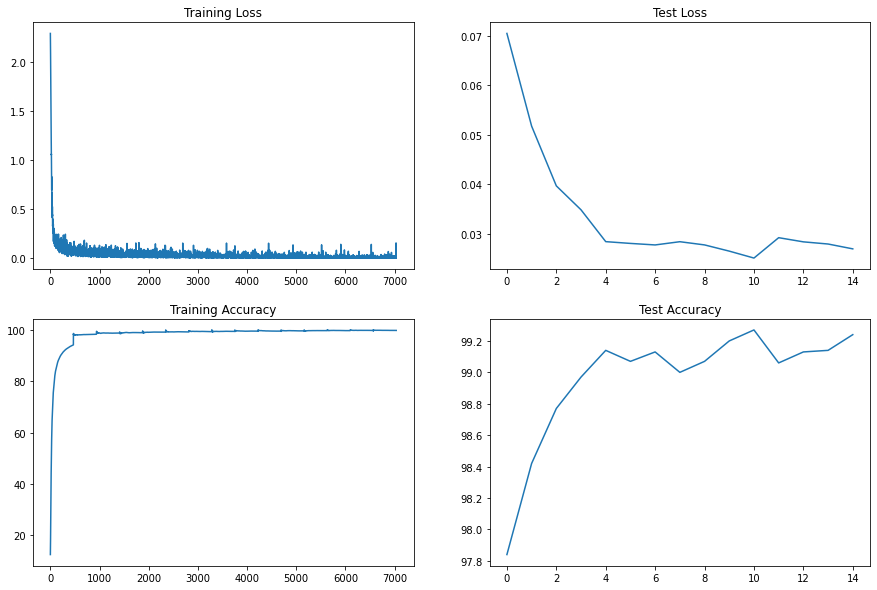

In [11]:
import numpy as np
fig, axs = plt.subplots(2,2,figsize=(15,10))
#train_losses=plt.plot(list(range(len(train_loss))),train_loss.cpu().detach().numpy(),color="r",label="Train "+typ)
#print (train_losses)
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")